In [1]:
!pip install pandas_datareader
!pip install tsfresh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 11.6 MB/s eta 0:00:00


In [32]:
#Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute

import pandas_datareader.data as web

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
#Загрузка набора данных о цене акций IBM
df = web.DataReader("IBM", 'stooq')["High"]
df.head()

Date
2024-06-28    173.4600
2024-06-27    172.5000
2024-06-26    172.6800
2024-06-25    175.7526
2024-06-24    178.4599
Name: High, dtype: float64

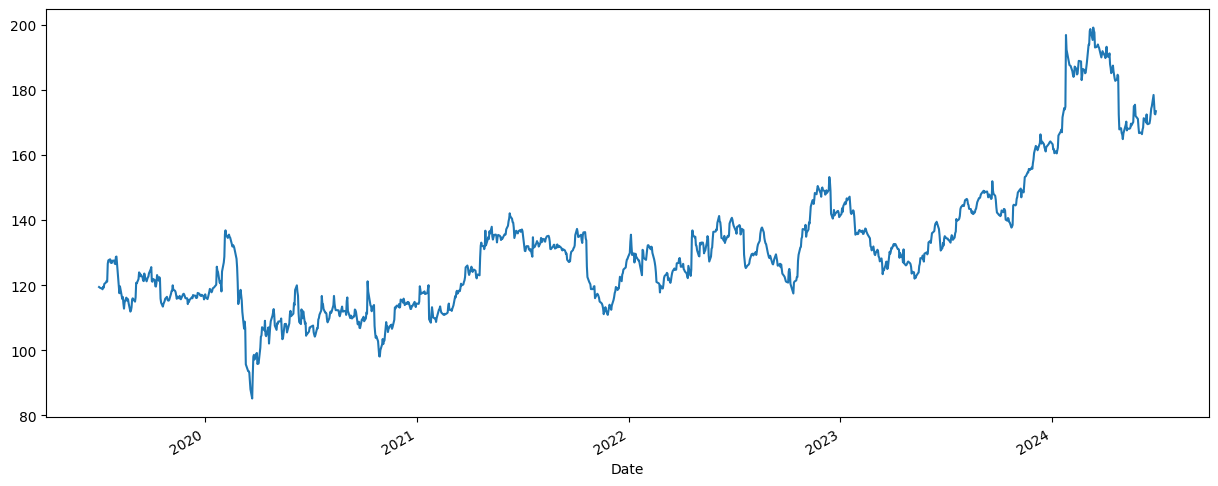

In [4]:
#Визуализация
plt.figure(figsize=(15, 6))
df.plot(ax=plt.gca())
plt.show()

In [5]:
#Приводим набор данных к виду, необходимому для использования функции плавающего окна
df_melted = pd.DataFrame({"high": df.copy()})
df_melted["date"] = df_melted.index
df_melted["Symbols"] = "IBM"

df_melted.head()

,high,date,Symbols
Date,,,
2024-06-28,173.4600,2024-06-28,IBM
2024-06-27,172.5000,2024-06-27,IBM
2024-06-26,172.6800,2024-06-26,IBM
2024-06-25,175.7526,2024-06-25,IBM
2024-06-24,178.4599,2024-06-24,IBM


In [6]:
#Использование функции скользящего окна
df_rolled = roll_time_series(df_melted, column_id="Symbols", column_sort="date",
                             max_timeshift=20, min_timeshift=5)

/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(
Rolling: 100%|██████████| 1256/1256 [00:10<00:00, 124.37it/s]


In [7]:
df_rolled.head()

,high,date,Symbols,id
0,119.404,2019-07-03,IBM,"(IBM, 2019-07-11 00:00:00)"
1,119.131,2019-07-05,IBM,"(IBM, 2019-07-11 00:00:00)"
2,118.936,2019-07-08,IBM,"(IBM, 2019-07-11 00:00:00)"
3,118.702,2019-07-09,IBM,"(IBM, 2019-07-11 00:00:00)"
4,119.473,2019-07-10,IBM,"(IBM, 2019-07-11 00:00:00)"


In [9]:
#Извлечение признаков из временных рядов
X = extract_features(df_rolled.drop("Symbols", axis=1),
                     column_id="id", column_sort="date", column_value="high",
                     impute_function=impute, show_warnings=False)

Feature Extraction: 100%|██████████| 1251/1251 [01:36<00:00, 13.02it/s]


In [10]:
X.head()

high__variance_larger_than_standard_deviation  \
IBM 2019-07-11                                            0.0   
    2019-07-12                                            0.0   
    2019-07-15                                            0.0   
    2019-07-16                                            0.0   
    2019-07-17                                            0.0   

                high__has_duplicate_max  high__has_duplicate_min  \
IBM 2019-07-11                      0.0                      0.0   
    2019-07-12                      0.0                      0.0   
    2019-07-15                      0.0                      0.0   
    2019-07-16                      0.0                      0.0   
    2019-07-17                      0.0                      0.0   

                high__has_duplicate  high__sum_values  high__abs_energy  \
IBM 2019-07-11                  0.0           714.845      85167.646607   
    2019-07-12                  0.0           835.176      99647.196168   
    2019-07-15                  0.0           955.995     114244.426929   
    2019-07-16                  0.0          1077.263     128950.354753   
    2019-07-17                  0.0          1198.335     143608.783937   

                high__mean_abs_change  high__mean_change  \
IBM 2019-07-11               0.349400          -0.041000   
    2019-07-12               0.479833           0.154500   
    2019-07-15               0.481000           0.202143   
    2019-07-16               0.477000           0.233000   
    2019-07-17               0.445778           0.185333   

                high__mean_second_derivative_central  high__median  ...  \
IBM 2019-07-11                             -0.000125      119.1650  ...   
    2019-07-12                              0.140500      119.1990  ...   
    2019-07-15                              0.063417      119.3015  ...   
    2019-07-16                              0.051571      119.4040  ...   
    2019-07-17                              0.004812      119.4385  ...   

                high__fourier_entropy__bins_5  high__fourier_entropy__bins_10  \
IBM 2019-07-11                       1.386294                        1.386294   
    2019-07-12                       1.039721                        1.039721   
    2019-07-15                       0.950271                        1.332179   
    2019-07-16                       0.500402                        0.950271   
    2019-07-17                       0.450561                        0.867563   

                high__fourier_entropy__bins_100  \
IBM 2019-07-11                         1.386294   
    2019-07-12                         1.386294   
    2019-07-15                         1.609438   
    2019-07-16                         1.609438   
    2019-07-17                         1.791759   

                high__permutation_entropy__dimension_3__tau_1  \
IBM 2019-07-11                                       1.039721   
    2019-07-12                                       1.054920   
    2019-07-15                                       1.329661   
    2019-07-16                                       1.351784   
    2019-07-17                                       1.386294   

                high__permutation_entropy__dimension_4__tau_1  \
IBM 2019-07-11                                       1.098612   
    2019-07-12                                       1.386294   
    2019-07-15                                       1.609438   
    2019-07-16                                       1.791759   
    2019-07-17                                       1.945910   

                high__permutation_entropy__dimension_5__tau_1  \
IBM 2019-07-11                                       0.693147   
    2019-07-12                                       1.098612   
    2019-07-15                                       1.386294   
    2019-07-16                                       1.609438   
    2019-07-17                                      

In [11]:
X = X.set_index(X.index.map(lambda x: x[1]), drop=True)
X.index.name = "last_date"
X.head()

,high__variance_larger_than_standard_deviation,high__has_duplicate_max,high__has_duplicate_min,high__has_duplicate,high__sum_values,high__abs_energy,high__mean_abs_change,high__mean_change,high__mean_second_derivative_central,high__median,...,high__fourier_entropy__bins_5,high__fourier_entropy__bins_10,high__fourier_entropy__bins_100,high__permutation_entropy__dimension_3__tau_1,high__permutation_entropy__dimension_4__tau_1,high__permutation_entropy__dimension_5__tau_1,high__permutation_entropy__dimension_6__tau_1,high__permutation_entropy__dimension_7__tau_1,high__query_similarity_count__query_None__threshold_0.0,high__mean_n_absolute_max__number_of_maxima_7
last_date,,,,,,,,,,,,,,,,,,,,,
2019-07-11,0.0,0.0,0.0,0.0,714.845,85167.646607,0.349400,-0.041000,-0.000125,119.1650,...,1.386294,1.386294,1.386294,1.039721,1.098612,0.693147,-0.000000,2.708050,0.0,131.969271
2019-07-12,0.0,0.0,0.0,0.0,835.176,99647.196168,0.479833,0.154500,0.140500,119.1990,...,1.039721,1.039721,1.386294,1.054920,1.386294,1.098612,0.693147,-0.000000,0.0,131.969271
2019-07-15,0.0,0.0,0.0,0.0,955.995,114244.426929,0.481000,0.202143,0.063417,119.3015,...,0.950271,1.332179,1.609438,1.329661,1.609438,1.386294,1.098612,0.693147,0.0,119.613286
2019-07-16,0.0,0.0,0.0,0.0,1077.263,128950.354753,0.477000,0.233000,0.051571,119.4040,...,0.500402,0.950271,1.609438,1.351784,1.791759,1.609438,1.386294,1.098612,0.0,119.946429
2019-07-17,0.0,0.0,0.0,0.0,1198.335,143608.783937,0.445778,0.185333,0.004812,119.4385,...,0.450561,0.867563,1.791759,1.386294,1.945910,1.791759,1.609438,1.386294,0.0,120.223714


In [13]:
y = df_melted.set_index("date").sort_index().high.shift(-1)

In [17]:
#Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [18]:
X_train_selected = select_features(X_train, y_train)

In [22]:
#Построение модели
model = LinearRegression()

model.fit(X_train_selected, y_train)

LinearRegression()

In [20]:
#Получение предсказаний
X_test_selected = X_test[X_train_selected.columns]

y_pred = pd.Series(model.predict(X_test_selected), index=X_test_selected.index)

In [35]:
y_pred.isna().sum()

0

In [37]:
#Последнее значение пустое, так что удалим его
y_test.isna()

date
2023-06-30    False
2023-07-03    False
2023-07-05    False
2023-07-06    False
2023-07-07    False
              ...  
2024-06-24    False
2024-06-25    False
2024-06-26    False
2024-06-27    False
2024-06-28     True
Name: high, Length: 251, dtype: bool

In [39]:
#Оценка модели
mse = mean_squared_error(y_test[:-1], y_pred[:-1])
r2 = r2_score(y_test[:-1], y_pred[:-1])

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 13.790988149132088
R^2 Score: 0.9607094340722698


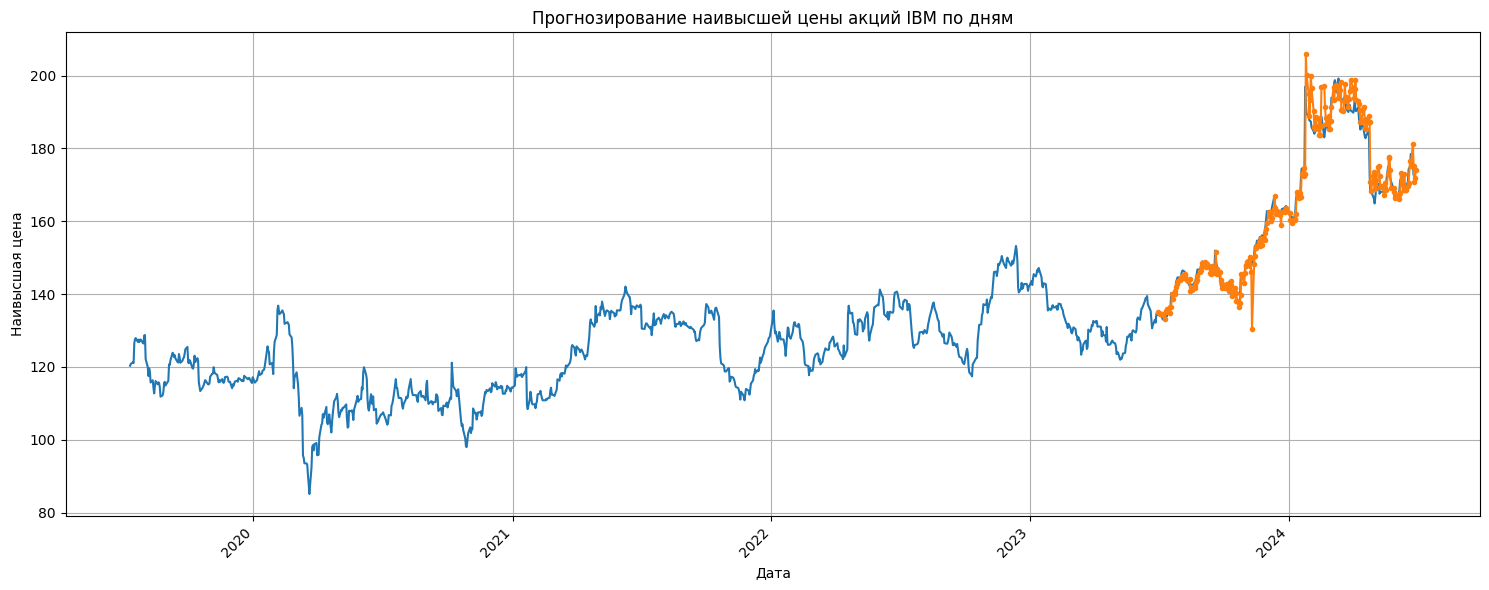

In [29]:
plt.figure(figsize=(15, 6))

y.plot(ax=plt.gca())
y_pred.plot(ax=plt.gca(), legend=None, marker=".")
# Добавление подписей и заголовка
plt.xlabel('Дата')
plt.ylabel('Наивысшая цена')
plt.title('Прогнозирование наивысшей цены акций IBM по дням')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Показ графика
plt.show()